# Delaunayovská triangulace

**Triangulací** (v rovině) rozumíme rozdělení rovinného útvaru $\Omega$ na množinu navzájem disjunktních trojúhelníků $T_i$, tj.

$$\Omega = \cup_i T_i$$
a pro $i\ne j$ je
$$
dim(T_i \cap T_j) < 2.
$$

**Konformní** triangulací nazveme takovou triangulaci pro kterou dva sousední trojúhelníky sdílející společnou hranu sdílejí také dva vrcholy.

**Delaunayoská triangulace** je taková konformní triangulace, že uvnitř kružnice opsaného libovolnému z trojúhelníků není žádný vrchol.

## Inkrementální algoritmus 

Též Bowyerův-Watsonův algoritmus, triangulace je pro danou množinu bodů sestavována postupně přidáváním bodů.

1. Vytvoříme základní triangulaci (např. dostatečně velký trojúhelník nebo obdélní rozdělený na 2 trojúhelníky).
1. Pro každý bod triangulace $p$:
    1. Nalezneme takový trojúhelník, že $p \in T$. Tento trojůhelník označíme.
    1. Pro všechny sousedy označených trojúhelníku zkontrolujeme zda se $p$ nachází uvnitř příslušné opsané kružnice. Pokud ano, označíme i příslušného souseda a pokračujeme kontrolou jeho sousedů. Pomocí rekurentního algoritmu tak vytvoříme množinu trjůhelníků jejichž opsané kružnice obsahují bod $p$.
    1. Označenou množinu vyjmeme z triangulace a vrcholy jejího obvodu spojíme s $p$. 

In [1]:
using Plots;
pyplot();

In [2]:
using StaticArrays;
using LinearAlgebra;

In [3]:
"Representation of a point in 2D space"
Point = SVector{2,Float64};

In [4]:
"""
    Triangle

Representation of a triangle from a triangulation. The triangle is given by its vertices
in the array v[4] (first vertex is also in v[4]), cicumcenter c, square of circumradius r2, and its three neighbors.
"""
struct Triangle
  v  :: SVector{4,Point}
  c  :: Point
  r2 :: Float64
  neigh :: SizedVector{3,Union{Triangle,Nothing}} 
end

Triangle

In [5]:
function circumcenter(p1, p2, p3)
    c1 = (p1 .+ p2) ./ 2
    n1 = Point(p2[2]-p1[2], p1[1] - p2[1])
    c2 = (p2 .+ p3) ./ 2
    n2 = Point(p3[2]-p2[2], p2[1] - p3[1])
    u = [n1 n2] \ (c2 - c1)
    return c1 .+ n1*u[1]
end

circumcenter (generic function with 1 method)

In [6]:
"""
    Triangle(p1, p2, p3)

Builds a triangle from three veritces (sets neighbours to "nothing")
"""
function Triangle(p1, p2, p3)
    c  = circumcenter(p1, p2, p3)
    r2 = dot(c-p1,c-p1)
    @assert dot(c-p2,c-p2) ≈ r2
    @assert dot(c-p3,c-p3) ≈ r2
    Triangle([p1,p2,p3,p1], c, r2, [nothing, nothing, nothing])
end

Triangle

In [7]:
Triangulation = Set{Triangle}

Set{Triangle}

In [8]:
a = Point([0,0]);
b = Point([1,0]);
c = Point([1,1]);
d = Point([0,1]);

In [9]:
t1 = Triangle(b,d,a);
t2 = Triangle(d,b,c);
t1.neigh[1] = t2
t2.neigh[1] = t1

Triangle(SArray{Tuple{2},Float64,1,2}[[1.0, 0.0], [0.0, 1.0], [0.0, 0.0], [1.0, 0.0]], [0.5, 0.5], 0.5, Union{Nothing, Triangle}[Triangle(SArray{Tuple{2},Float64,1,2}[[0.0, 1.0], [1.0, 0.0], [1.0, 1.0], [0.0, 1.0]], [0.5, 0.5], 0.5, Union{Nothing, Triangle}[Triangle(#= circular reference @-4 =#), nothing, nothing]), nothing, nothing])

In [10]:
"Outer normal to i-th edge"
normal(t::Triangle, i::Int) = Point( t.v[i+1][2] - t.v[i][2], t.v[i][1] - t.v[i+1][1]) ./ norm(t.v[i+1] - t.v[i])

normal

In [11]:
T = Triangulation([t1,t2]);

In [12]:
function plot_triangle!(t::Triangle, linestyle=:solid, linecolor=:black)
    plot!(plt,[t.v[i][1] for i ∈ 1:4], [t.v[i][2] for i ∈ 1:4], linestyle=linestyle, linecolor=linecolor)
end

function plot_triangulation!(T::Triangulation; linestyle=:solid, linecolor=:black)
    for t ∈ T
        plot_triangle!(t, linestyle, linecolor)
    end
end

plot_triangulation! (generic function with 1 method)

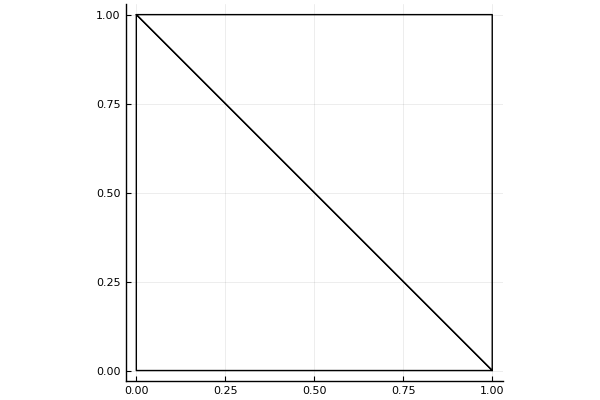

In [13]:
plt = plot(aspect_ratio=:equal, legend=:none)
plot_triangulation!(T)
plt

In [14]:
"Cross product in 2D"
×(v1::Point, v2::Point) = v1[1]*v2[2] - v1[2]*v2[1]    

×

In [15]:
import Base.∈

In [16]:
"Test if p is inside a triangle"
∈(p::Point,t::Triangle) = all( [ dot(p - t.v[i], normal(t,i)) <= 0 for i=1:3 ] ) 

Base.:∈

In [17]:
Point(0.2,0.6) ∈ t1

true

In [18]:
Point(0.8,0.8) ∈ t1

false

In [19]:
p = Point(0.8,0.8)

2-element SArray{Tuple{2},Float64,1,2} with indices SOneTo(2):
 0.8
 0.8

In [20]:
i=3
(p-t1.v[i]) × normal(t1,i)

-0.8

In [21]:
"""
    find_triangle(p::Point, t::Trianle)

Searches the triangulation for a triangle containing point p starting with triangle t.
"""
function find_triangle(p::Point, t::Triangle)
    for i = 1:3
        if dot(p - t.v[i], normal(t,i)) > 0
            if t.neigh[i] == nothing
                error("Didn't found a triangle!")
            else
                return find_triangle(p, t.neigh[i])
            end
        end
    end 
    return t
end

find_triangle

In [22]:
find_triangle(p::Point, T::Triangulation) = find_triangle(p, first(T))

find_triangle (generic function with 2 methods)

In [23]:
find_triangle(Point(0.2,0.6), T).v[1:3]

3-element Array{SArray{Tuple{2},Float64,1,2},1}:
 [1.0, 0.0]
 [0.0, 1.0]
 [0.0, 0.0]

In [24]:
find_triangle(Point(0.8,0.8), T).v[1:3]

3-element Array{SArray{Tuple{2},Float64,1,2},1}:
 [0.0, 1.0]
 [1.0, 0.0]
 [1.0, 1.0]

In [25]:
"Build the set of triangles violating the Delaunay condition"
function form_cavity(p::Point, T::Triangulation)
    M = Triangulation()

    function check_triangle(t)
        if t ∈ M return end
        if dot(p-t.c,p-t.c) < t.r2
            push!(M,t)
            for n ∈ t.neigh
                if n != nothing
                    check_triangle(n)
                end
            end
        end
    end
    
    t0 = find_triangle(p, T)
    check_triangle(t0)
    return M
end

form_cavity

In [26]:
M = form_cavity(p,T);

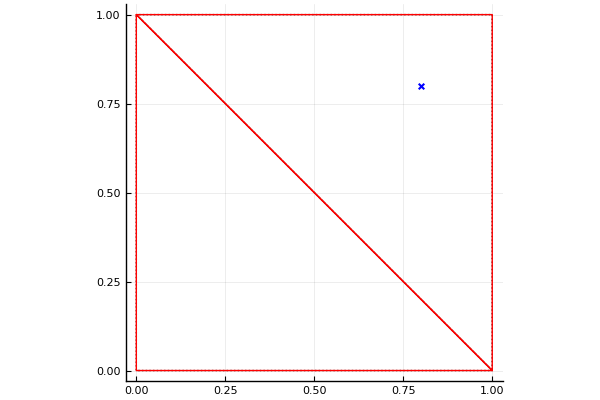

In [27]:
plt = plot(aspect_ratio=:equal, legend=:none)
plot_triangulation!(T, linestyle=:dot, linecolor=:black)
plot_triangulation!(M, linestyle=:solid, linecolor=:red)
plot!(plt,[p[1]],[p[2]], markershape=:x, markercolor=:blue)

In [28]:
"Return a structure with the information about cavity boundary (edges + neighbor triangles)"
function cavity_boundary(M::Triangulation)
    b = Dict{Point,Tuple{Point,Union{Triangle,Nothing}}}()
    for t ∈ M
        for i = 1:3
            if t.neigh[i]==nothing || t.neigh[i] ∉ M
                b[t.v[i]] = (t.v[i+1], t.neigh[i])
            end
        end
    end
    
    # Sorting
    boundary = Array{Tuple{Point,Point,Union{Triangle,Nothing}},1}()
    p1 = first(keys(b))
    for i=1:length(b)
        p2, t = b[p1]
        push!(boundary, (p1, p2, t) )
        p1 = p2
    end
    return boundary
end;

In [29]:
cavity_boundary(M)

4-element Array{Tuple{SArray{Tuple{2},Float64,1,2},SArray{Tuple{2},Float64,1,2},Union{Nothing, Triangle}},1}:
 ([0.0, 0.0], [1.0, 0.0], nothing)
 ([1.0, 0.0], [1.0, 1.0], nothing)
 ([1.0, 1.0], [0.0, 1.0], nothing)
 ([0.0, 1.0], [0.0, 0.0], nothing)

In [30]:
"Connects the boundary of the cavity with p"
function remesh_cavity(p::Point, M::Triangulation)
    b = cavity_boundary(M)
    N = [Triangle(b[i][1],b[i][2],p) for i=1:length(b)]
    for i=1:length(b)-1
        N[i].neigh[2] = N[i+1]
        N[i+1].neigh[3] = N[i]
    end
    N[end].neigh[2] = N[1]
    N[1].neigh[3] = N[end]
    
    for i=1:length(b)
        N[i].neigh[1] = b[i][3]
        if N[i].neigh[1] != nothing
            n = N[i].neigh[1]
            for k=1:3
                if n.v[k] == N[i].v[2]
                    n.neigh[k] = N[i]
                end
            end
        end
    end
    
    return N
end
    

remesh_cavity

In [31]:
function insert_point!(p::Point, T::Triangulation, draw=false)
    M = form_cavity(p,T)
    setdiff!(T, M)

    if draw
        plot_triangulation!(T, linestyle=:dot, linecolor=:black)
        plot_triangulation!(M, linestyle=:solid, linecolor=:red)
        plot!([p[1]],[p[2]], markershape=:x, markercolor=:blue)
    end
    
    N = remesh_cavity(p,M)
    for n ∈ N
        push!(T,n)
    end
 end

insert_point! (generic function with 2 methods)

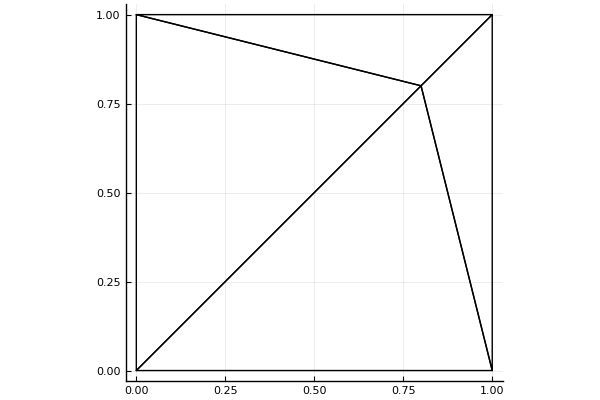

In [32]:
plt = plot(aspect_ratio=:equal, legend=:none)
T = Triangulation([t1,t2]);
insert_point!(Point(0.8,0.8), T);
plot_triangulation!(T)
plt

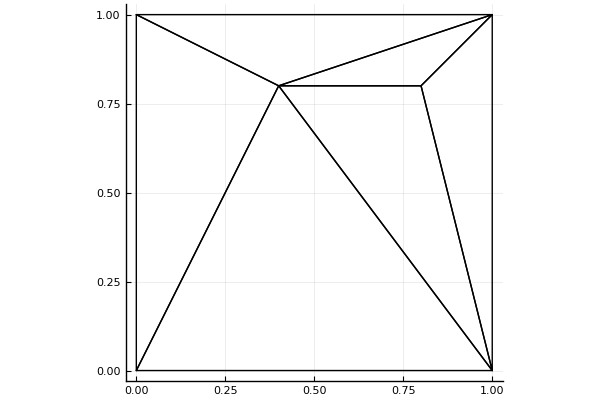

In [33]:
plt = plot(aspect_ratio=:equal, legend=:none)
insert_point!(Point(0.4,0.8), T, false);
plot_triangulation!(T)
plt

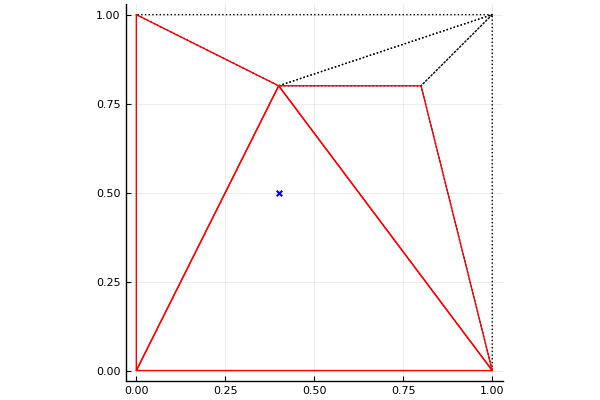

In [34]:
plt = plot(aspect_ratio=:equal, legend=:none)
insert_point!(Point(0.4,0.5), T, true);
plt

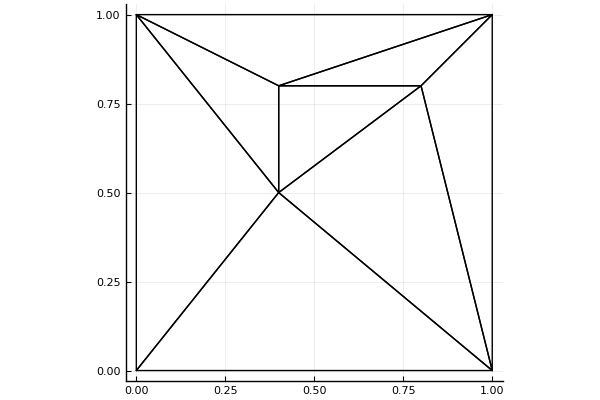

In [35]:
plt = plot(aspect_ratio=:equal, legend=:none)
plot_triangulation!(T)
plt

In [36]:
T = Triangulation([t1,t2]);

for p ∈ [Point(0.5+0.4*cos(ϕ), 0.5+0.4*sin(ϕ)) for ϕ ∈ collect(range(0,2π,length=36))[1:end-1]]
    insert_point!(p, T)
end

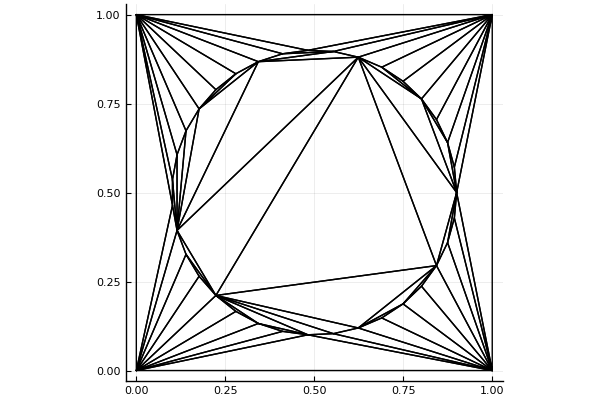

In [37]:
plt = plot(aspect_ratio=:equal, legend=:none)
plot_triangulation!(T)
plt

In [38]:
for x ∈ range(0, 1, length=20)
    for y ∈ range(0, 1, length=20)
        v = Point(x,y)
        if norm(v-Point(0.5,0.5)) < 0.375
            insert_point!(v, T)
        end
    end
end

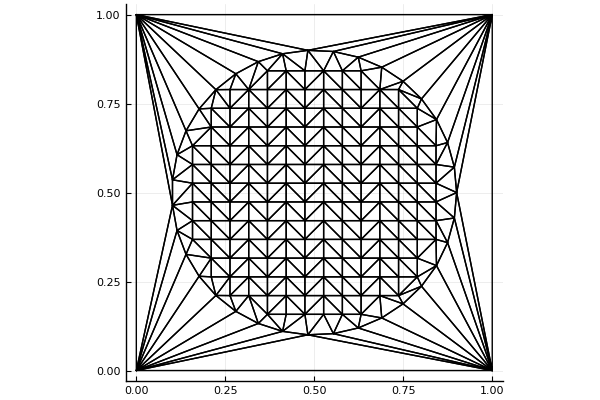

In [39]:
plt = plot(aspect_ratio=:equal, legend=:none)
plot_triangulation!(T)
plt

In [40]:
function delete_triangle!(T::Triangulation, t::Triangle)
    delete!(T,t)
    for n ∈ t.neigh
        if n ≠ nothing
            for j = 1:3
                if n.neigh[j]==t
                    n.neigh[j] = nothing
                end
            end
        end
    end
end

delete_triangle! (generic function with 1 method)

In [41]:
for t ∈ T
    if any([t.v[j][1] ≈ 0 for j=1:3]) || any([t.v[j][1] ≈ 1 for j=1:3])
        delete_triangle!(T,t)
    end
end

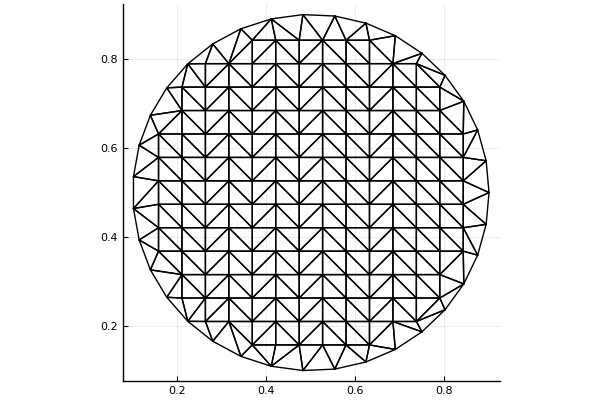

In [42]:
plt = plot(aspect_ratio=:equal, legend=:none)
plot_triangulation!(T)
plt